# 4. Advanced Turnout: Logit Model

This notebook implements a logit model of turnout. This model is more sophisticated than the simple enthusiasm-based model, as it takes into account a wider range of factors that influence turnout, such as demographics, social influence, and campaign mobilization.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

pd.options.display.max_rows = 10

## Load Datasets

In [2]:
STUDENTS_PATH = "../data/students.csv"
EDGES_PATH = "../data/edges.csv"

try:
    students_df = pd.read_csv(STUDENTS_PATH)
    edges_df = pd.read_csv(EDGES_PATH)
    print("Successfully loaded datasets.")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you have run the data generation script first.")

Successfully loaded datasets.


## Construct the Graph

In [3]:
G = nx.Graph()

# Add nodes with attributes from the students dataframe
for index, row in students_df.iterrows():
    node_id = row['id']
    attributes = row.to_dict()
    G.add_node(node_id, **attributes)

# Add edges with attributes from the edges dataframe
for index, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], layer=row['layer'], weight=row['weight'])

## Logit Turnout Model

In [4]:
from src.advanced_models import BoundedConfidenceElectionModel

class LogitTurnoutElectionModel(BoundedConfidenceElectionModel):
    def __init__(self, graph: nx.Graph, **kwargs):
        super().__init__(graph, **kwargs)
        self.turnout_model = LogisticRegression()

        # Create a dummy dataset for training the turnout model
        X = pd.get_dummies(students_df[['hostel', 'batch', 'dept']])
        y = (students_df['baseline_turnout_propensity'] > 0.5).astype(int)
        self.turnout_model.fit(X, y)

    def update_turnout_propensity(self, agent):
        # Get the agent's features
        agent_features = pd.get_dummies(pd.DataFrame([agent.__dict__])[['hostel', 'batch', 'dept']])
        
        # Align the columns of the agent's features with the training data
        X_cols = self.turnout_model.feature_names_in_
        agent_features = agent_features.reindex(columns=X_cols, fill_value=0)

        # Predict the probability of voting
        prob = self.turnout_model.predict_proba(agent_features)[0][1]

        # Add social influence
        neighbor_nodes = list(self.grid.neighbors(agent.node_id))
        if neighbor_nodes:
            neighbor_turnout = np.mean([self.grid.nodes[n]['agent'].turnout_propensity for n in neighbor_nodes])
            prob = (prob + neighbor_turnout) / 2

        agent.next_turnout_propensity = prob

## Simple Simulation

In [5]:
model = LogitTurnoutElectionModel(G.copy())
model.release_manifestos()

opinions_over_time = []
turnout_over_time = []

for i in range(10):
    model.step()
    
    # Collect data
    opinions = {post: {cand.id: [] for cand in cands} for post, cands in model.candidates_by_post.items()}
    turnout = []
    for agent in model.agents:
        for post, op in agent.opinion.items():
            for cand_id, score in op.items():
                opinions[post][cand_id].append(score)
        turnout.append(agent.turnout_propensity)
    
    avg_opinions = {post: {cand_id: np.mean(scores) for cand_id, scores in op.items()} for post, op in opinions.items()}
    avg_turnout = np.mean(turnout)
    
    opinions_over_time.append(avg_opinions)
    turnout_over_time.append(avg_turnout)

/Users/ashishmishra/bits-election-simulator/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Releasing Manifestos ---


## Sanity Plots

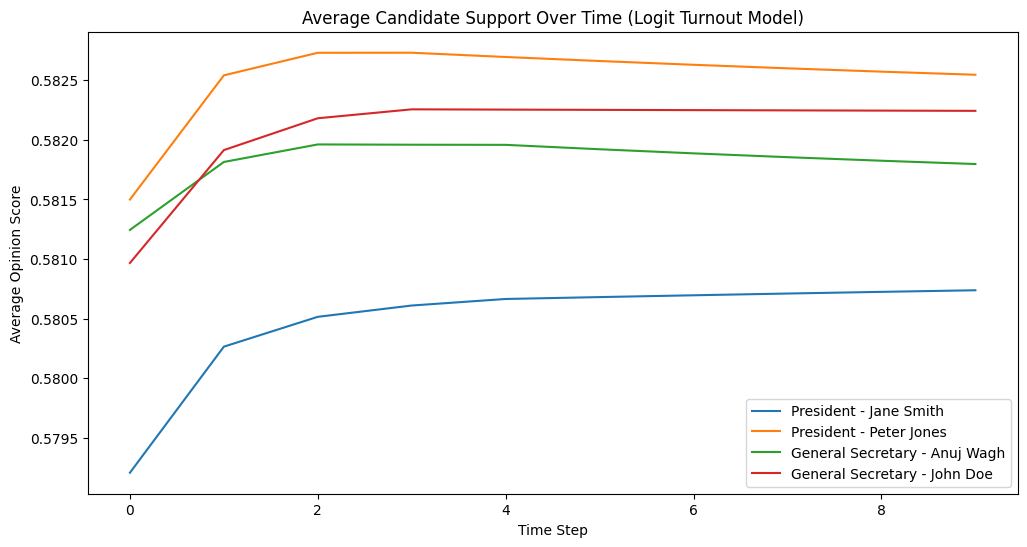

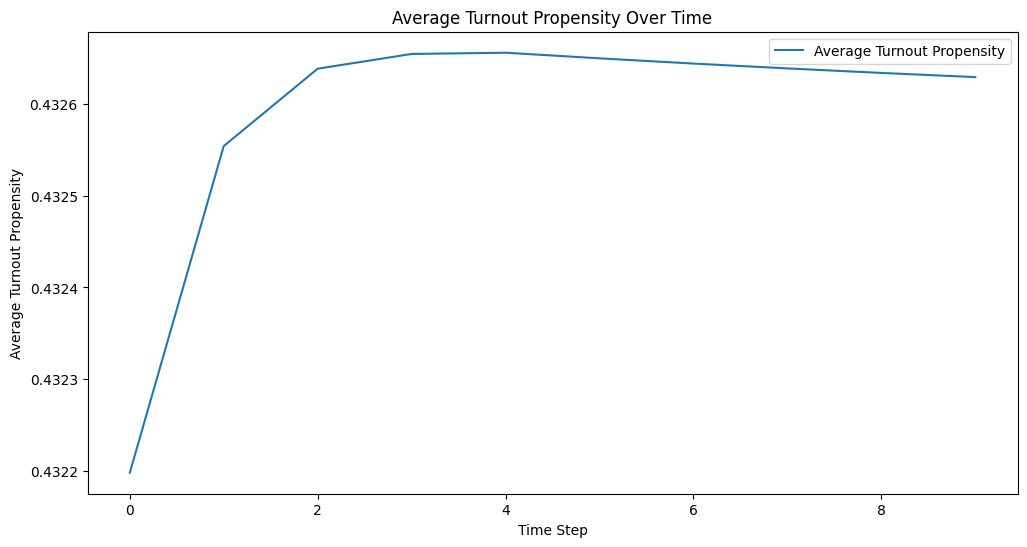

In [6]:
# Opinion Dynamics
fig, ax = plt.subplots(figsize=(12, 6))

for post, candidates in model.candidates_by_post.items():
    for cand in candidates:
        ax.plot([o[post][cand.id] for o in opinions_over_time], label=f'{post} - {cand.name}')

ax.set_title('Average Candidate Support Over Time (Logit Turnout Model)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Average Opinion Score')
ax.legend()
plt.show()

# Turnout Dynamics
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(turnout_over_time, label='Average Turnout Propensity')
ax.set_title('Average Turnout Propensity Over Time')
ax.set_xlabel('Time Step')
ax.set_ylabel('Average Turnout Propensity')
ax.legend()
plt.show()